In [7]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [8]:
import os
import numpy as np
import torch
import proplot as pplt
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mpl_toolkits.basemap import Basemap
import baselines
import utils



== Num. data points: 2253780.0 




RuntimeError: Error(s) in loading state_dict for UNetRegression:
	Missing key(s) in state_dict: "net.first.0.0.weight", "net.first.0.0.bias", "net.first.0.1.weight", "net.first.0.1.bias", "net.first.0.1.eps". 
	Unexpected key(s) in state_dict: "net.first.0.weight", "net.first.0.bias", "net.first.1.weight", "net.first.1.bias", "net.first.1.eps". 

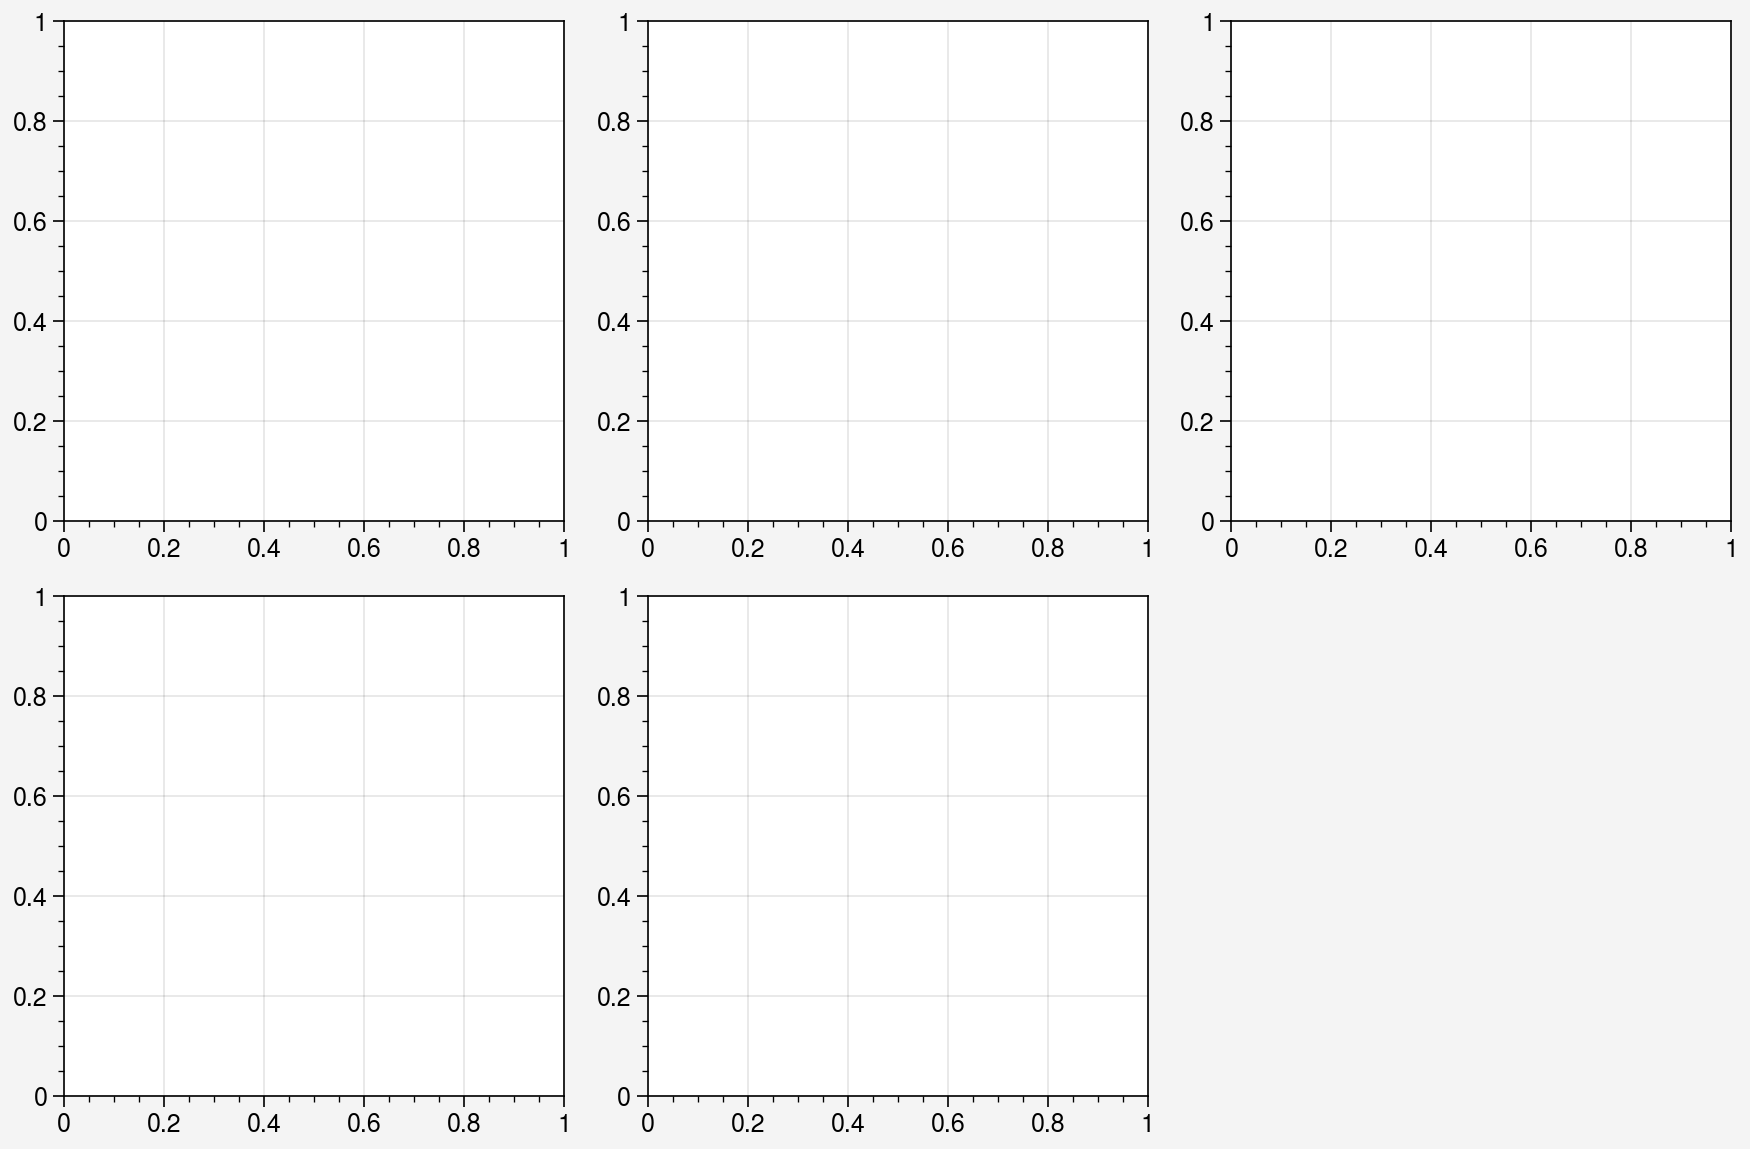

In [9]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
pi, pj = 48, 205
ext = [-135.0, 20.0, -60.0, 52.0]
lon = ext[0] + (pj / 256) * (ext[2] - ext[0])
lat = ext[3] - (pi / 128) * (ext[3] - ext[1])
grads = []
b = 3
fig, axs = pplt.subplots([[1, 2, 3], [4, 5, 0]], share=False)

for depth in range(5):
    C, _, Y, M  = utils.load_training_data(
        "../data/training_data.pkl", standardize_weather=True, log_so4=False,
        standardize_so4=True, year_averages=False, remove_zeros=True
    )
    ax = axs[depth]
    ckptdir = f"../results-rf/detrending/time_reg/depth{depth + 1}/checkpoints/"
    ckpt = f"{ckptdir}/{sorted(os.listdir(ckptdir))[-1]}"
    model = baselines.UNetRegression.load_from_checkpoint(ckpt).to(dev)

    # add time to C (the treatment here)
    nt, nd, nr, nc = C.shape
    if model._hparams["add_time"]:
        time = np.zeros((nt, 2, nr, nc))
        for i in range(nr):
            for j in range(nc):
                time[:, 0, i, j] = np.arange(nt) // 12
                time[:, 1, i, j] = np.arange(nt) % 12
        C = np.concatenate([C, time], axis=1)
        nd += 2

    C.requires_grad_(True)
    g = torch.zeros_like(Y)
    g[..., (pi-b):(pi+b+1), (pj-b):(pj+b+1)] = 1
    out = model(C)
    out.backward(gradient=g)
    grad = C.grad
    K = torch.ones((1, 1, 3, 3), device=dev)
    grad = torch.cat(
        [F.conv2d(grad[0, j].view(1, 1, nr, nc), K, padding='same') for j in range(nd)],
        axis=1
    )
    grad = grad.norm(1, dim=1)
    l, u = grad[M > 0].amin(), grad[M > 0].amax()
    grad = (grad - l) / (u - l)
    grads.append(grad * M[0])

    grads = torch.cat(grads).mean(0).cpu().numpy()
    m = Basemap(projection="cyl", *ext, ax=ax)
    m.drawcoastlines(0.5)
    m.drawstates(0.05)
    m.drawcountries(0.15)
    ax.set_xlim(-100.0, -63.0)
    ax.set_ylim(25.0, 50.0)
    ax.scatter(lon, lat, c="blue", m=".", s=200)
    m.imshow(grads[::-1], vmin=0.0, vmax=0.75)
